# Group 21  - Chess Piece Classification
## Deep Learning Project


|      |     Student Name     |     Student Email    | 
|---   |         ---          |           ---          |
| 1    |      Ana Miguel Sal       |20221645@novaims.unl.pt| 
| 2    |      David Castro      |          20220688@novaims.unl.pt    | 
| 3    |      Ehis Jegbefumwen        |20221015@novaims.unl.pt| 
| 4    |      Evans Onorieru|        20220657@novaims.unl.pt     | 
| 5    |      Ricardo Montenegro      |20221359@novaims.unl.pt| 

### Data Source
https://www.kaggle.com/datasets/s4lman/chess-pieces-dataset-85x85

### Abstract

Regarding data preprocessing, we do not need to perform image normalization since we already have all images with the same size. However we have an unbalanced dataset, so we must transform it to a balanced one. We will do this by creating new images from the original ones and changing them a bit. In this way, we will do data augmentation and flip rotate, Zoom in and zoom out, change the contrast, brightness and translation of the original images of the classes with less images. This will be done for each image until we have at least 239 images per class, which is the class with the highest number of images (pawn). Then we will only consider the first random 239 of each class and we split the folder organization of our dataset into train and test folders with 20% of all images to the test an 80% for the training. After that we split the dataset into train and validation and we took 20% of the 80% for the validation dataset and the rest for the training, which is 64% of all dataset.

## 1. Imports

In [1]:
import time
import shutil
import zipfile

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential, layers
import numpy as np
import os
from PIL import Image, ImageEnhance
import glob
import random

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image_dataset_from_directory
import tensorflow as tf

## 2. Load Images

In [2]:
# Set the machine
gdrive = True
# Set the connection string
path = '/content/drive/MyDrive/NOVA IMS/DL/project/'
main_folder = "data/"
# If using Google Drive
if gdrive:
    # Setup drive
    from google.colab import drive
    drive.mount('/content/drive')        
    # Transfer zip dataset to the current virtual machine
    t0 = time.time()
    shutil.copyfile(path + 'archive.zip', 'archive.zip')
    # Extract files
    zip_ = zipfile.ZipFile('archive.zip')
    zip_.extractall()
    zip_.close()
    print("File transfer completed in %0.3f seconds" % (time.time() - t0))
    path = ""

Mounted at /content/drive
File transfer completed in 1.722 seconds


## 3. Data Preprocessing

*   Data Augmentation
*   Save those new images to create a new balanced dataset



In [3]:
# Creation of an augmentation pipeline

augmentation = Sequential([layers.RandomFlip(), 
                           layers.RandomRotation(factor=0.2), 
                           layers.RandomZoom(height_factor=0.1, width_factor=0.1),
                           layers.RandomContrast(factor=0.25),
                           layers.RandomBrightness(factor=0.2),
                           layers.RandomTranslation(height_factor=(-0.1, 0.1), width_factor=(-0.1, 0.1))], 
                           name="my_augmentation_pipeline")

Create a function that loops for each image in each of the subfolders and create a modify version of each image (trials) times. Then each of the new image created is then saved in the same folder of the existing original image.

In [4]:
def augment_images(folder_path, trials):
    # create an instance of the image data generator with your augmentation pipeline
    datagen = ImageDataGenerator(preprocessing_function=augmentation)

    # get a list of all image filenames in the folder
    image_filenames = [f for f in os.listdir(folder_path) if f.endswith('.jpg') or f.endswith('.png')]

    # loop through each image file
    for filename in image_filenames:
        # open the image file
        image_path = os.path.join(folder_path, filename)
        with Image.open(image_path) as image:
            # expand the image dimension and apply augmentation pipeline 'trials' times
            x = np.expand_dims(np.array(image), axis=0)
            for i in range(trials):
                # generate an augmented image
                augmented_image = datagen.flow(x, batch_size=1)[0][0]

                # save the augmented image with a new filename
                new_filename = f'{os.path.splitext(filename)[0]}_augmented_{i}.jpg'
                new_image_path = os.path.join(folder_path, new_filename)
                Image.fromarray(augmented_image.astype('uint8')).save(new_image_path)

    print('Image augmentation complete!')


Run this function for all subfolders, except for the 'pawn' folder.

In [5]:
augment_images('/content/data/bishop', 4)
augment_images('/content/data/king', 7)
augment_images('/content/data/knight', 4)
augment_images('/content/data/queen', 7)
augment_images('/content/data/rook', 4)


Image augmentation complete!
Image augmentation complete!
Image augmentation complete!
Image augmentation complete!
Image augmentation complete!


Count how many images each subfolder has:

In [6]:
# Set the path to the dataset directory
dataset_path = path + main_folder

# Get a list of subdirectories (i.e., class folders) in the dataset directory
subdirs = glob.glob(os.path.join(dataset_path, '*'))

# Loop through each subdirectory and count the number of images
for subdir in subdirs:
    num_images = len(os.listdir(subdir))
    print('Class {}: {} images'.format(os.path.basename(subdir), num_images))

Class queen: 272 images
Class bishop: 335 images
Class knight: 355 images
Class pawn: 239 images
Class king: 272 images
Class rook: 360 images


Limit all subfolder to a maximum of 239 images, randomly sorted.

In [7]:
# set the path to the folder containing the class folders
parent_folder = '/content/data/'

# set the desired number of images for each class
num_images_per_class = 239

# loop through each class folder
for class_folder in os.listdir(parent_folder):
    # set the path to the current class folder
    class_folder_path = os.path.join(parent_folder, class_folder)
    # check if it is a folder and not a file
    if os.path.isdir(class_folder_path):
        # get a list of all image filenames in the folder
        image_filenames = [f for f in os.listdir(class_folder_path) if f.endswith('.jpg') or f.endswith('.png')]
        # shuffle the image filenames
        random.shuffle(image_filenames)
        # loop through the excess images and remove them
        for filename in image_filenames[num_images_per_class:]:
            file_path = os.path.join(class_folder_path, filename)
            os.remove(file_path)
        # print the number of images remaining in the folder
        num_images = len(os.listdir(class_folder_path))
        print(f'Class {class_folder}: {num_images} images')
print('Our dataset is now balanced!')


Class queen: 239 images
Class bishop: 239 images
Class knight: 239 images
Class pawn: 239 images
Class king: 239 images
Class rook: 239 images
Our dataset is now balanced!


## 4. Changing the architecture of the dataset - Train and Test Split

1.   Train and validation Split
2.   Set ds_train, ds_val, ds_test



Split the image dataset into Train and Test data by changing organization/structure of the folders.

In [8]:
# Set path to your data folder
data_path = path + main_folder

# Set path to your destination folder
destination_path = path

# Set test data size (fraction)
test_size = 0.2

# Create destination folders
train_path = os.path.join(destination_path, "training_data")
os.makedirs(train_path, exist_ok=True)

test_path = os.path.join(destination_path, "testing_data")
os.makedirs(test_path, exist_ok=True)

# Loop through each class folder in data folder
for class_folder in os.listdir(data_path):
    class_folder_path = os.path.join(data_path, class_folder)

    # Split files into train and test sets
    files = os.listdir(class_folder_path)
    train_files, test_files = train_test_split(files, test_size=test_size)

    # Copy train files to destination folder
    train_class_folder = os.path.join(train_path, class_folder)
    os.makedirs(train_class_folder, exist_ok=True)
    for file_name in train_files:
        file_path = os.path.join(class_folder_path, file_name)
        shutil.copy(file_path, train_class_folder)

    # Copy test files to destination folder
    test_class_folder = os.path.join(test_path, class_folder)
    os.makedirs(test_class_folder, exist_ok=True)
    for file_name in test_files:
        file_path = os.path.join(class_folder_path, file_name)
        shutil.copy(file_path, test_class_folder)


Confirm if the cell above was successfully acomplished 

In [9]:
for folder in os.listdir(train_path):
    folder_path = os.path.join(train_path, folder)
    print(f"Train - {folder}: {len(os.listdir(folder_path))} files")

for folder in os.listdir(test_path):
    folder_path = os.path.join(test_path, folder)
    print(f"Test - {folder}: {len(os.listdir(folder_path))} files")


Train - queen: 191 files
Train - bishop: 191 files
Train - knight: 191 files
Train - pawn: 191 files
Train - king: 191 files
Train - rook: 191 files
Test - queen: 48 files
Test - bishop: 48 files
Test - knight: 48 files
Test - pawn: 48 files
Test - king: 48 files
Test - rook: 48 files


Defines a list of parameters for the ``image_dataset_from_directory``.

In [10]:
image_size=(85, 85)
crop_to_aspect_ratio=True
color_mode='rgb'
batch_size=64
label_mode="categorical"
validation_split=0.2
shuffle=True
seed=0

Loads the training data using the ``image_dataset_from_directory`` function. Performs an automatic split in training and validation data via ``validation_split``. Note that by assigning value to the ``validation_split`` parameter, the ``image_dataset_from_directory()`` function will split the training data.

In [11]:
# Generate an object of type tf.data.Dataset 
ds_train, ds_val = image_dataset_from_directory('/content/training_data', 
                                                image_size=image_size,
                                                crop_to_aspect_ratio=crop_to_aspect_ratio,
                                                color_mode=color_mode,
                                                batch_size=batch_size,
                                                label_mode=label_mode,
                                                subset='both',
                                                validation_split=validation_split, 
                                                shuffle=shuffle,
                                                seed=seed)
# Check object properties
print("\nObject's type:\t", type(ds_train))
print("Is it a tf.data.Dataset?\t R:",isinstance(ds_train, tf.data.Dataset))
print("Classes:", ds_train.class_names)

Found 1146 files belonging to 6 classes.
Using 917 files for training.
Using 229 files for validation.

Object's type:	 <class 'tensorflow.python.data.ops.batch_op._BatchDataset'>
Is it a tf.data.Dataset?	 R: True
Classes: ['bishop', 'king', 'knight', 'pawn', 'queen', 'rook']


Creating an iterator 'iter_train' for the training dataset.

In [12]:
iter_train = iter(ds_train)
batch_x_train, batch_y_train = iter_train.next()
print(batch_x_train.shape, batch_y_train.shape)
print("\nSample of x_train:", batch_x_train[0, 0:2, 0:2, 0])
print("\nSample of y_train:", batch_y_train[0:5])
print("Sample average of y_train:", tf.reduce_mean(batch_y_train))

(64, 85, 85, 3) (64, 6)

Sample of x_train: tf.Tensor(
[[102.  94.]
 [100.  93.]], shape=(2, 2), dtype=float32)

Sample of y_train: tf.Tensor(
[[0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]], shape=(5, 6), dtype=float32)
Sample average of y_train: tf.Tensor(0.16666667, shape=(), dtype=float32)


Plot images loaded with ``BatchDataset``.

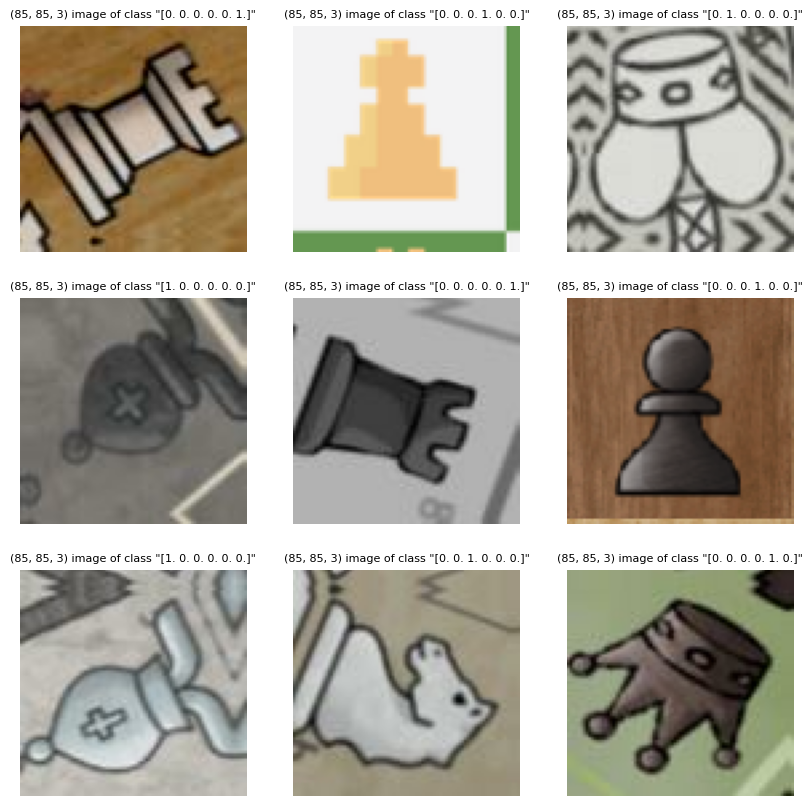

In [13]:
def show_sample_batch(ds, grid_size=(3, 3)):
    n_images = grid_size[0]*grid_size[1]
    # Get a batch via iteration
    iter_ = iter(ds)
    batch_x, batch_y = iter_.next()
    batch_x, batch_y = batch_x[0:n_images], batch_y[0:n_images]
    # Plot the images
    plt.figure(figsize=(10, 10))
    for i, (img, y) in enumerate(zip(batch_x, batch_y)):
        ax = plt.subplot(grid_size[0], grid_size[1],  i + 1)
        plt.imshow(tf.cast(img, tf.int32))
        plt.title("{} image of class \"{}\"".format(img.shape, y), size=8)
        plt.axis("off")

show_sample_batch(ds_train)

Loads the testing data using the ``image_dataset_from_directory()`` function.

In [14]:
ds_test = image_dataset_from_directory('/content/testing_data', 
                                       image_size=image_size,
                                       crop_to_aspect_ratio=crop_to_aspect_ratio,
                                       color_mode=color_mode,
                                       batch_size=batch_size,
                                       label_mode=label_mode,                                     
                                       shuffle=shuffle,
                                       seed=seed)

Found 288 files belonging to 6 classes.
